# imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
assert tf.__version__ >= "2.0"

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ignore convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")

2024-04-30 19:43:49.216387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# data importation

In [2]:
closures = pd.read_csv("Zeeland_Closures.csv")
weather_1 = pd.read_csv("Zeeland primary 1.csv")
weather_2 = pd.read_csv("Zeeland primary 2.csv")
missing_1 = pd.read_csv("Missing 1 (Grand Rapids).csv")
missing_2 = pd.read_csv("Missing 2 (Holland).csv", dtype=str)
hourly = pd.read_csv("Zeeland Hourly Data.csv")

print(closures.info(), weather_1.info(), weather_2.info(), missing_1.info(), missing_2.info(), hourly.info())
#154 expected closures
#21365 weather data points

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          154 non-null    object
 1   Closure Type  154 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          14140 non-null  object 
 1   NAME             14140 non-null  object 
 2   LATITUDE         14140 non-null  float64
 3   LONGITUDE        14140 non-null  float64
 4   ELEVATION        14140 non-null  float64
 5   DATE             14140 non-null  object 
 6   DAPR             15 non-null     float64
 7   DAPR_ATTRIBUTES  15 non-null     object 
 8   DASF             2 non-null      float64
 9   DASF_ATTRIBUTES  2 non-null      object 
 10  MDPR             15 no

# data pre-processing - date/time

In [3]:
weather_1['DATE'] = pd.to_datetime(weather_1['DATE'], dayfirst = True, format= '%m/%d/%y')
weather_2['DATE'] = pd.to_datetime(weather_2['DATE'], dayfirst = True, format= '%m/%d/%y')
missing_1['DATE'] = pd.to_datetime(missing_1['DATE'], dayfirst=True,format= '%m/%d/%y' )
missing_2['DATE'] = pd.to_datetime(missing_2['DATE'], dayfirst=True, format= '%m/%d/%y')
closures['DATE'] = pd.to_datetime(closures['DATE'], format = '%m/%d/%y')
hourly['DATE'] = pd.to_datetime(hourly['DATE'], format = '%Y%m%d %H:%M')

print(weather_1['DATE'].value_counts(), weather_2['DATE'].value_counts(), missing_1['DATE'].value_counts(), missing_2['DATE'].value_counts(), closures['DATE'].value_counts(), hourly['DATE'].value_counts())
#interpretting 1961 as 2061 in weather_1 and Zeeland_closures

DATE
2061-01-01    1
1986-12-28    1
1986-12-17    1
1986-12-18    1
1986-12-19    1
             ..
1973-11-30    1
1973-12-01    1
1973-12-02    1
1973-12-03    1
1999-12-31    1
Name: count, Length: 14140, dtype: int64 DATE
2000-01-01    1
2013-09-01    1
2013-09-12    1
2013-09-11    1
2013-09-10    1
             ..
2006-08-05    1
2006-08-04    1
2006-08-03    1
2006-08-02    1
2021-12-31    1
Name: count, Length: 7127, dtype: int64 DATE
1985-02-01    1
1985-02-02    1
1985-02-27    1
1985-02-26    1
1985-02-25    1
1985-02-24    1
1985-02-23    1
1985-02-22    1
1985-02-21    1
1985-02-20    1
1985-02-19    1
1985-02-18    1
1985-02-17    1
1985-02-16    1
1985-02-15    1
1985-02-14    1
1985-02-13    1
1985-02-12    1
1985-02-11    1
1985-02-10    1
1985-02-09    1
1985-02-08    1
1985-02-07    1
1985-02-06    1
1985-02-05    1
1985-02-04    1
1985-02-03    1
1985-02-28    1
Name: count, dtype: int64 DATE
2011-02-03    1
2018-04-18    1
2021-01-23    1
2021-01-22    1
2021-01-2

In [4]:
import datetime
def fix_date(x):

    if x.year > 2024:

        year = x.year - 100

    else:

        year = x.year

    return datetime.date(year,x.month,x.day)

weather_1['DATE']=weather_1['DATE'].apply(fix_date)
weather_1['DATE']=pd.to_datetime(weather_1['DATE'], format='%Y-%m-%d')

closures['DATE'] = closures['DATE'].apply(fix_date)
closures['DATE'] = pd.to_datetime(closures['DATE'], format = '%m/%d/%y')

print (closures.info(), closures.head())
print(weather_1.info(), weather_1.head())
print(weather_2.info(), weather_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE          154 non-null    datetime64[ns]
 1   Closure Type  154 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 2.5+ KB
None         DATE Closure Type
0 1961-04-17       closed
1 1977-12-09       closed
2 1978-01-09       closed
3 1978-01-10       closed
4 1978-01-26       closed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   STATION          14140 non-null  object        
 1   NAME             14140 non-null  object        
 2   LATITUDE         14140 non-null  float64       
 3   LONGITUDE        14140 non-null  float64       
 4   ELEVATION        14140 non-null  float64    

# data join 

In [5]:
weather = pd.concat([weather_1, weather_2, missing_1, missing_2])
og = pd.merge(closures, weather, how='right', on='DATE')
print(og.head(), og.info(), og['DATE'].value_counts(), og['NAME'].value_counts(), og['Closure Type'].value_counts())
#expected number of data points #expected number of closures

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21365 entries, 0 to 21364
Data columns (total 75 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             21365 non-null  datetime64[ns]
 1   Closure Type     154 non-null    object        
 2   STATION          21365 non-null  object        
 3   NAME             21365 non-null  object        
 4   LATITUDE         21365 non-null  object        
 5   LONGITUDE        21365 non-null  object        
 6   ELEVATION        21365 non-null  object        
 7   DAPR             128 non-null    float64       
 8   DAPR_ATTRIBUTES  128 non-null    object        
 9   DASF             2 non-null      float64       
 10  DASF_ATTRIBUTES  2 non-null      object        
 11  MDPR             218 non-null    float64       
 12  MDPR_ATTRIBUTES  218 non-null    object        
 13  MDSF             3 non-null      float64       
 14  MDSF_ATTRIBUTES  3 non-null      objec

In [6]:
date_range=pd.date_range('1961-01-01', '2021-12-31')
missing_dates=date_range[~date_range.isin(og['DATE'])]
winter_missing_dates = missing_dates[missing_dates.month.isin([10,11,12,1,2,3,4,5])]
print(missing_dates, winter_missing_dates)
#915 missing dates
#761 missing winter weather days

DatetimeIndex(['1979-08-01', '1979-08-02', '1979-08-03', '1979-08-04',
               '1979-08-05', '1979-08-06', '1979-08-07', '1979-08-08',
               '1979-08-09', '1979-08-10',
               ...
               '2021-11-27', '2021-12-05', '2021-12-07', '2021-12-20',
               '2021-12-21', '2021-12-23', '2021-12-26', '2021-12-27',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', length=915, freq=None) DatetimeIndex(['1985-05-28', '1987-05-28', '1990-04-13', '1991-01-13',
               '1995-01-23', '1995-01-24', '1995-01-25', '1995-01-26',
               '1995-02-05', '1995-02-12',
               ...
               '2021-11-27', '2021-12-05', '2021-12-07', '2021-12-20',
               '2021-12-21', '2021-12-23', '2021-12-26', '2021-12-27',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', length=761, freq=None)


# variables drops/additions/renames/filling null values

In [7]:
#remove unnecessary categories like all attribute data, time of observation, elevation, long/lat, and values that not all weather data had
dropped = og.drop(columns=['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DAPR', 'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'MDSF_ATTRIBUTES','PRCP_ATTRIBUTES', 'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'TOBS_ATTRIBUTES', 'SNOW_ATTRIBUTES','SNWD_ATTRIBUTES', 'WT01_ATTRIBUTES', 'WT02_ATTRIBUTES', 'WESD_ATTRIBUTES', 'WT03_ATTRIBUTES', 'WT04_ATTRIBUTES', 'WT05_ATTRIBUTES', 'WT06_ATTRIBUTES', 'WT07_ATTRIBUTES', 'WT08_ATTRIBUTES', 'WT09_ATTRIBUTES', 'WT15_ATTRIBUTES', 'WT16_ATTRIBUTES', 'WT17_ATTRIBUTES', 'WT18_ATTRIBUTES', 'WT11_ATTRIBUTES', 'WT14_ATTRIBUTES', 'DASF_ATTRIBUTES', 'DASF', 'TAVG_ATTRIBUTES', 'PGTM_ATTRIBUTES', 'WDF2_ATTRIBUTES', 'WDF5_ATTRIBUTES', 'WESF_ATTRIBUTES','WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES', 'AWND_ATTRIBUTES', 'TAVG', 'WT07', 'WT08', 'WT17', 'AWND', 'PGTM', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT02', 'WT09', 'WT14', 'WT15', 'WT16', 'WT18'])

#rename
dropped.rename(columns={'MDSF': 'MultidaySnowfallTotal', 'PRCP': 'PrecipitationTotal', 'SNOW':'SnowfallTotal', 'SNWD': 'SnowDepth', 'TMAX':'MaxTemp', 'TMIN':'MinTemp', 'WESD':'WaterEqGroundSnow', 'WT01':'Fog/IceFog/FreezingFog', 'WT03': 'Thunder', 'WT04': 'Ice/Sleet', 'WT05':'Hail', 'WT06':'Glaze','WT11': 'HighWinds','WESF':'WaterEqSnowfall', 'NAME':'Station'}, inplace=True)

In [8]:
#add day, month, year, and day of the week variables
add=dropped.sort_values(by='DATE')
add['Day']=dropped['DATE'].dt.day
add['Day of the Week']=add['DATE'].dt.day_name()
add['Month']=add['DATE'].dt.month
add['Year']=add['DATE'].dt.year

In [9]:
#add dummy variable for early dismissal the day before
add=add.sort_values(by='DATE')
target = 'early dismissal'
add['Previous Early Dismissal'] = add['Closure Type'].apply(lambda x: 1 if x==target else 0)
add['Previous Early Dismissal'] =add['Previous Early Dismissal'].shift(1)
add['Previous Early Dismissal'].fillna(0, inplace=True)

#add school year variable
add=add.sort_values(by='DATE')
add['School Year'] = add['DATE'].dt.year-(add['DATE'].dt.month<7)
add['School Year'] = add['School Year'].astype(int)

#add a shift in closures (to eventually create a cumsum of school days in the year)
add=add.sort_values(by='DATE')
add['Closure_shift']=add['Closure Type'].shift(+1).fillna(0)

In [10]:
#add mapping categorical variables
closure_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1}

closureshift_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1,
                       '0':0}

weekday_mapping = {'Monday': 0, 
                  'Tuesday' : 1, 
                  'Wednesday': 2, 
                  'Thursday':3, 
                  'Friday': 4,
                  'Saturday': 5, 
                  'Sunday':6}
station_mapping = {'HOLLAND, MI US': 0,
                  'GRAND RAPIDS GERALD R FORD INTERNATIONAL AIRPORT, MI US':1,
                  'HOLLAND 3.9 NNE, MI US':2}
add['Closure Type']=add['Closure Type'].map(closure_mapping)
add['Day of the Week']=add['Day of the Week'].map(weekday_mapping)
add['Station']=add['Station'].map(station_mapping)
add['Closure_shift']=add['Closure_shift'].map(closureshift_mapping)

#add total school days in the year
grouped=add.groupby('School Year')
add['Snow Days This Year']=grouped['Closure_shift'].cumsum()

In [11]:
#change all numerical data types of int64
add['WaterEqGroundSnow']=add['WaterEqGroundSnow'].astype('float64')
add['WaterEqSnowfall']=add['WaterEqSnowfall'].astype('float64')
add['SnowfallTotal']=add['SnowfallTotal'].astype('float64')
add['SnowDepth']=add['SnowDepth'].astype('float64')
add['PrecipitationTotal']=add['PrecipitationTotal'].astype('float64')

#fill null values strategically
add['MaxTemp']=add["MaxTemp"].interpolate()
add['MinTemp']=add["MinTemp"].interpolate()

#fill the rest of the null values
add=add.fillna(0)

add['Snow Days This Year'].value_counts()

Snow Days This Year
0.0     21211
1.0        42
2.0        32
3.0        24
4.0        17
5.0        11
6.0         8
7.0         6
8.0         5
9.0         4
10.0        2
11.0        1
12.0        1
13.0        1
Name: count, dtype: int64

In [12]:
#add previous day's weather data
wprevious=add.sort_values(by='DATE')
wprevious['Previous_MinTemp']=wprevious['MinTemp'].shift(1)
wprevious['Previous_MaxTemp']=wprevious['MaxTemp'].shift(1)
wprevious['Previous_SnowfallTotal']=wprevious['SnowfallTotal'].shift(1)
wprevious['Previous_SnowDepth']=wprevious['SnowDepth'].shift(1)
wprevious.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21365 entries, 0 to 21266
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      21365 non-null  datetime64[ns]
 1   Closure Type              21365 non-null  float64       
 2   Station                   21365 non-null  int64         
 3   MultidaySnowfallTotal     21365 non-null  float64       
 4   PrecipitationTotal        21365 non-null  float64       
 5   SnowfallTotal             21365 non-null  float64       
 6   SnowDepth                 21365 non-null  float64       
 7   MaxTemp                   21365 non-null  float64       
 8   MinTemp                   21365 non-null  float64       
 9   Fog/IceFog/FreezingFog    21365 non-null  float64       
 10  Thunder                   21365 non-null  float64       
 11  Ice/Sleet                 21365 non-null  float64       
 12  Hail                   

In [13]:
#add vectorlike data over 3 day period
vector=wprevious.sort_values(by='DATE')
vector['MinTempChange']=vector['MinTemp'].diff()
vector['MaxTempChange']=vector['MaxTemp'].diff()
vector['SnowfallTotalChange']=vector['SnowfallTotal'].diff()
vector['SnowDepthChange']=vector['SnowDepth'].diff()
vector['3DayVector_MinTemp']=vector['MinTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_MaxTemp']=vector['MaxTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowfallTotal']=vector['SnowfallTotalChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowDepth']=vector['SnowDepthChange'].rolling(window=3, min_periods=1).mean()
vector=vector.fillna(0)

vector.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21365 entries, 0 to 21266
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      21365 non-null  datetime64[ns]
 1   Closure Type              21365 non-null  float64       
 2   Station                   21365 non-null  int64         
 3   MultidaySnowfallTotal     21365 non-null  float64       
 4   PrecipitationTotal        21365 non-null  float64       
 5   SnowfallTotal             21365 non-null  float64       
 6   SnowDepth                 21365 non-null  float64       
 7   MaxTemp                   21365 non-null  float64       
 8   MinTemp                   21365 non-null  float64       
 9   Fog/IceFog/FreezingFog    21365 non-null  float64       
 10  Thunder                   21365 non-null  float64       
 11  Ice/Sleet                 21365 non-null  float64       
 12  Hail                   

# get rid of common breaks from school

In [14]:
#get rid of summer data
school = vector[~vector.DATE.dt.month.isin([6, 7, 8, 9])]

#get rid of winter break
school = school[~((school['Month']==12) & (school['Day']>22))]
school=school[~((school['Month']==1) & (school['Day']<3))]

#get rid of weekends
school=school[school['DATE'].dt.weekday<5]

#get rid of federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=school['DATE'].min(), end=school['DATE'].max())
school=school[~school['DATE'].isin(holidays)]

#get rid of fri of thanksgiving
bday = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
def get_thanksgiving_dates(year):
    # Find the fourth Thursday of November
    thanksgiving_date = pd.Timestamp(year, 11, 1) + relativedelta(weekday=4, weeks=3)
    # Get the dates for the day before and after Thanksgiving
    pre_thanksgiving = thanksgiving_date - pd.Timedelta(days=1)
    post_thanksgiving = thanksgiving_date + pd.Timedelta(days=1)
    return [pre_thanksgiving, thanksgiving_date, post_thanksgiving]
thanksgiving_dates = []
for year in range(1961,2021):
    thanksgiving_dates.extend(get_thanksgiving_dates(year))
thanksgiving_dates = [parse(date.strftime('%Y-%m-%d')) for date in thanksgiving_dates]
school=school[~school['DATE'].isin(thanksgiving_dates)]


print(school.info(),school['Closure Type'].value_counts())
#150 rather than 154 expected

<class 'pandas.core.frame.DataFrame'>
Index: 9238 entries, 2 to 21262
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      9238 non-null   datetime64[ns]
 1   Closure Type              9238 non-null   float64       
 2   Station                   9238 non-null   int64         
 3   MultidaySnowfallTotal     9238 non-null   float64       
 4   PrecipitationTotal        9238 non-null   float64       
 5   SnowfallTotal             9238 non-null   float64       
 6   SnowDepth                 9238 non-null   float64       
 7   MaxTemp                   9238 non-null   float64       
 8   MinTemp                   9238 non-null   float64       
 9   Fog/IceFog/FreezingFog    9238 non-null   float64       
 10  Thunder                   9238 non-null   float64       
 11  Ice/Sleet                 9238 non-null   float64       
 12  Hail                    

In [15]:
missing_dates = closures[~closures['DATE'].isin(school['DATE'])]
missing_dates=missing_dates.drop('Closure Type', axis = 1)
missing_info = pd.merge(vector, missing_dates, on='DATE', how='right')
school = pd.concat([missing_info, school])
school['Closure Type'].value_counts()

Closure Type
0.0    9088
1.0     154
Name: count, dtype: int64

In [16]:
full = school.drop(columns=['DATE','MaxTempChange', 'MinTempChange', 'Closure_shift', 'SnowfallTotalChange', 'SnowDepthChange'])

# data visualization, correlations, and more drops

In [17]:
closure_weather = full[full["Closure Type"] == 1]

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


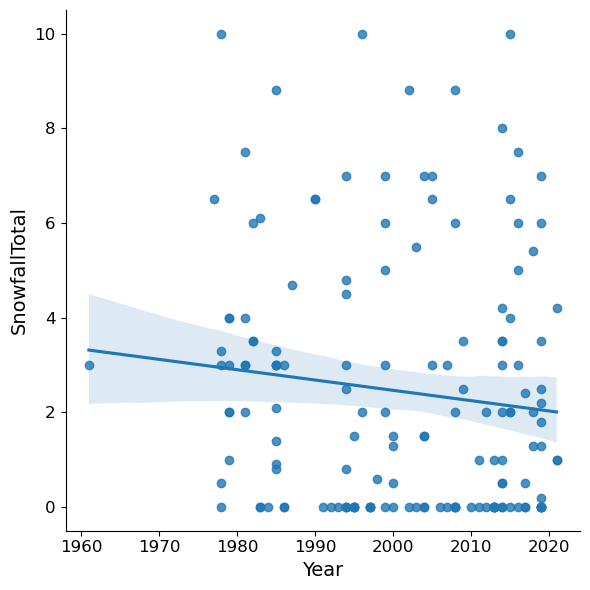

In [18]:
seaborn.lmplot( x="Year", y="SnowfallTotal", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


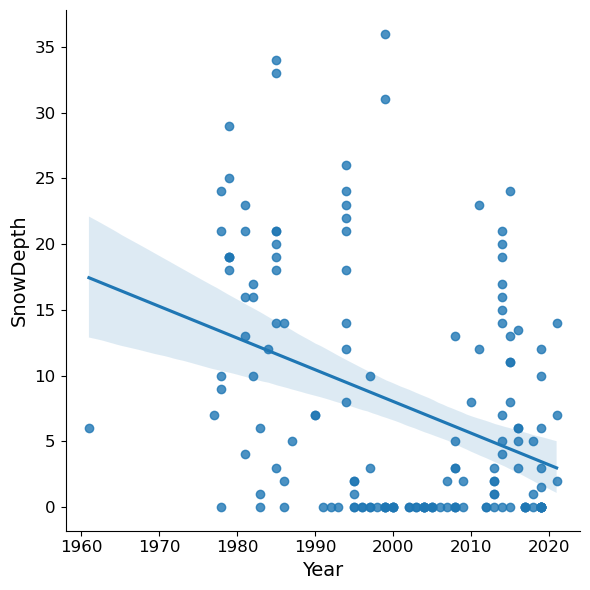

In [19]:
seaborn.lmplot( x="Year", y="SnowDepth", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


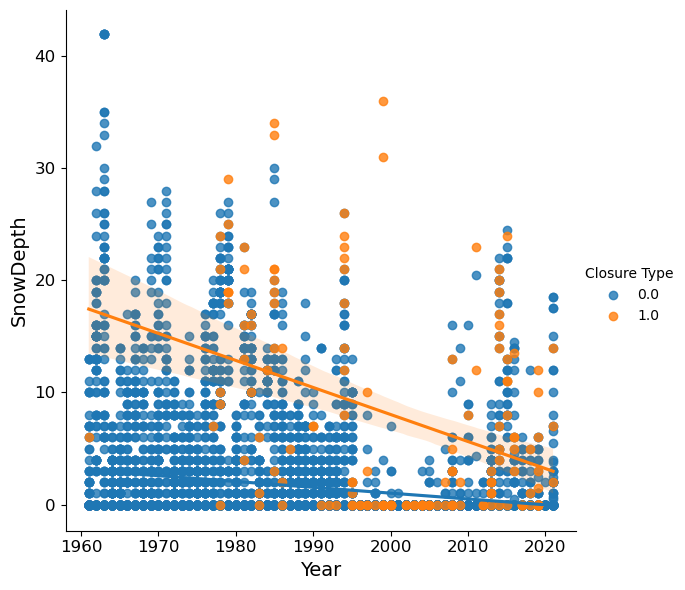

In [20]:
seaborn.lmplot( x="Year", y="SnowDepth", hue ="Closure Type",data = full, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


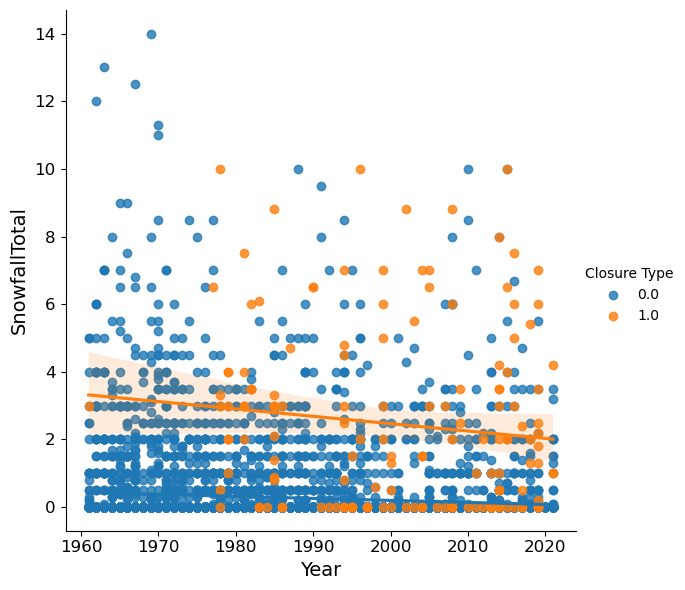

In [21]:
seaborn.lmplot( x="Year", y="SnowfallTotal", hue ="Closure Type",data = full, height = 6)

<Axes: xlabel='Day', ylabel='Month'>

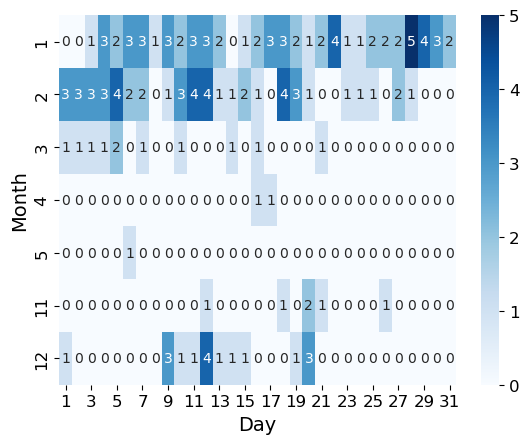

In [22]:
pivot_table = closure_weather.pivot_table(index = "Month", columns = "Day", aggfunc='size', fill_value=0)
seaborn.heatmap(pivot_table, annot=True, cmap='Blues', fmt ='d')

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


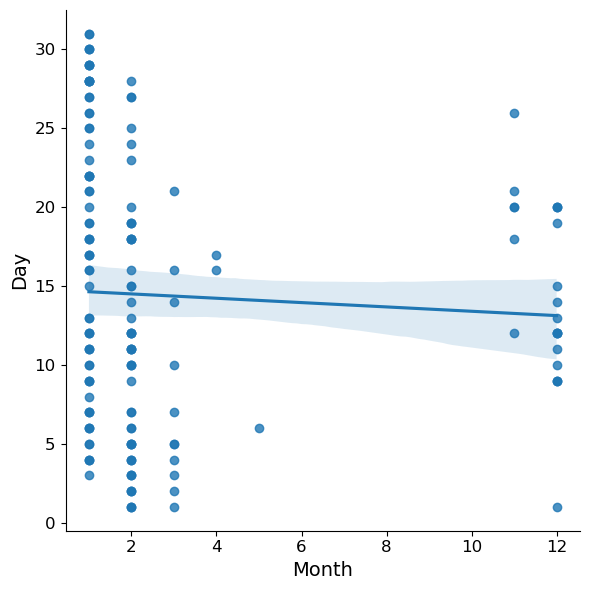

In [23]:
seaborn.lmplot( x="Month", y="Day", data=closure_weather, height=6)

In [24]:
full.corr()['Closure Type'].sort_values()

MaxTemp                    -0.146249
Previous_MaxTemp           -0.137122
MinTemp                    -0.131004
Previous_MinTemp           -0.122041
Month                      -0.086553
3DayVector_MaxTemp         -0.028766
3DayVector_MinTemp         -0.027695
Thunder                    -0.018085
Day                        -0.012746
Day of the Week            -0.010958
Hail                        0.008204
HighWinds                   0.016664
Ice/Sleet                   0.028732
MultidaySnowfallTotal       0.035325
Fog/IceFog/FreezingFog      0.045114
PrecipitationTotal          0.061699
Previous Early Dismissal    0.079912
School Year                 0.085293
Year                        0.086830
Glaze                       0.094285
3DayVector_SnowfallTotal    0.126399
3DayVector_SnowDepth        0.127229
Station                     0.127987
Previous_SnowDepth          0.135402
WaterEqSnowfall             0.140923
Previous_SnowfallTotal      0.174418
SnowDepth                   0.178107
W

In [25]:
ready = full.drop(columns=['3DayVector_MaxTemp', '3DayVector_MinTemp', 'Thunder', 'Day','Day of the Week' , 'Hail', 'HighWinds', 'Ice/Sleet', 'MultidaySnowfallTotal', 'Fog/IceFog/FreezingFog' ])

In [26]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.146249
Previous_MaxTemp           -0.137122
MinTemp                    -0.131004
Previous_MinTemp           -0.122041
Month                      -0.086553
PrecipitationTotal          0.061699
Previous Early Dismissal    0.079912
School Year                 0.085293
Year                        0.086830
Glaze                       0.094285
3DayVector_SnowfallTotal    0.126399
3DayVector_SnowDepth        0.127229
Station                     0.127987
Previous_SnowDepth          0.135402
WaterEqSnowfall             0.140923
Previous_SnowfallTotal      0.174418
SnowDepth                   0.178107
WaterEqGroundSnow           0.192513
Snow Days This Year         0.211572
SnowfallTotal               0.273841
Closure Type                1.000000
Name: Closure Type, dtype: float64

<Axes: >

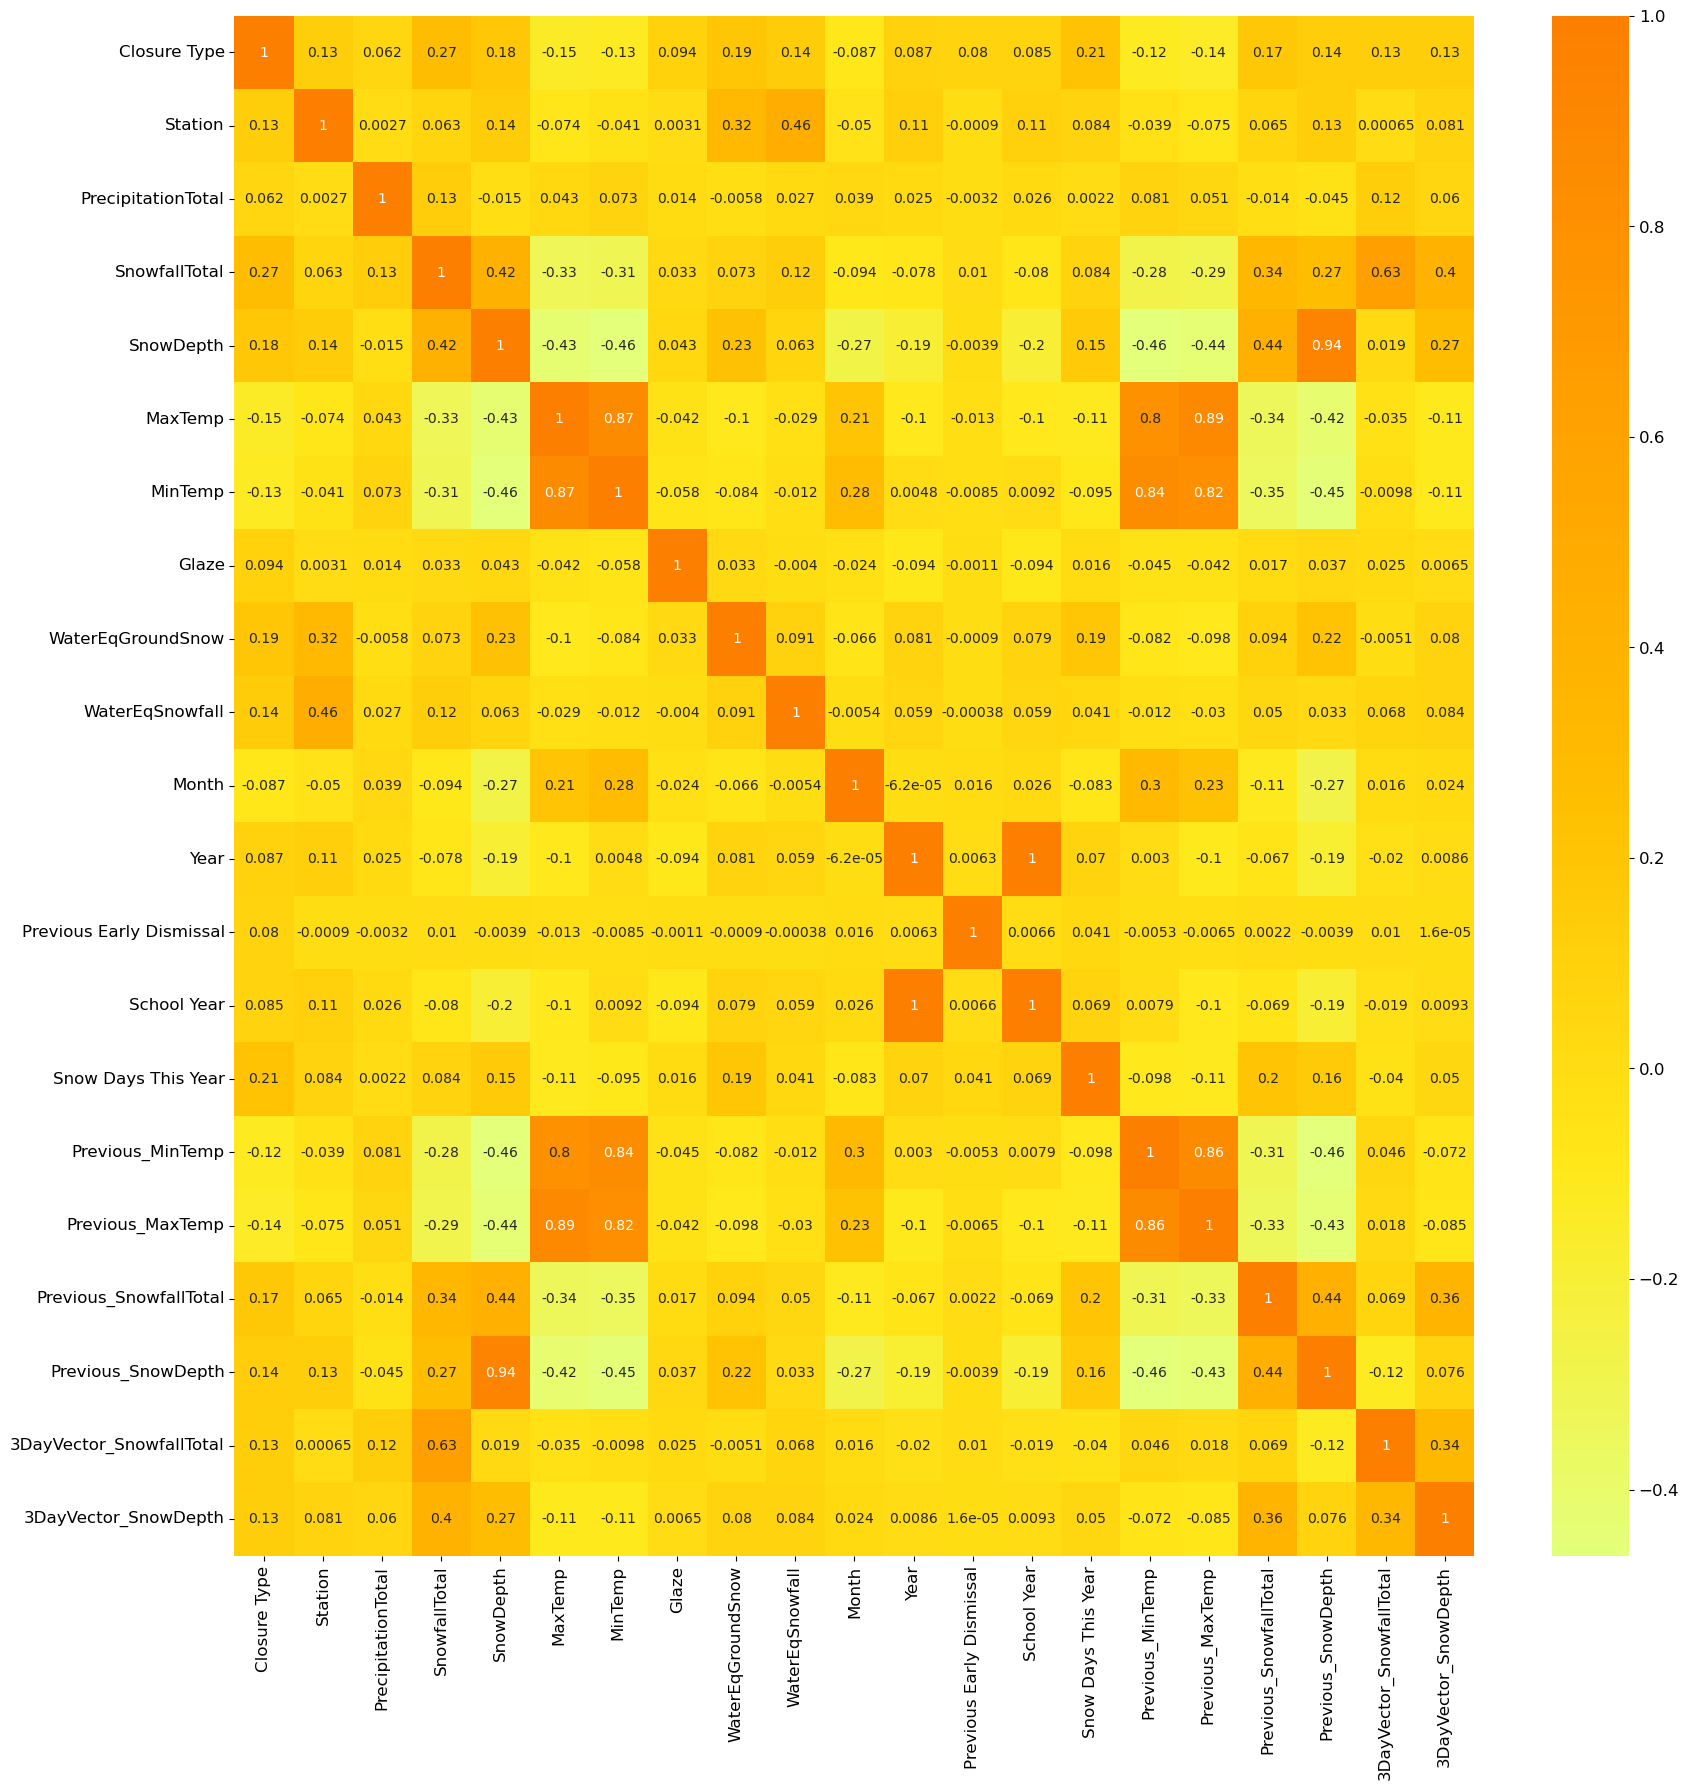

In [27]:
plt.figure(figsize=(20,20))
corr = ready.corr()
seaborn.heatmap(corr, cmap = 'Wistia', annot= True)

# data splitting

In [28]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.858750119557036


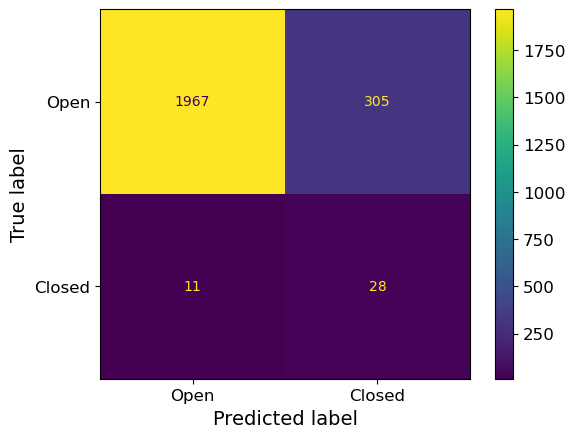

Test set accuracy score for Logistic Regression Model is  0.8632626568585028
Test set recall score for Logistic Regression Model is  0.717948717948718
Test set precision score for Logistic Regression Model is  0.08408408408408409
Test set F1 score for Logistic Regression Model is  0.15053763440860216


In [31]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree

In [32]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [33]:
dt_model = DecisionTreeClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 2, min_samples_split=5, random_state=42)
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9750387780647148


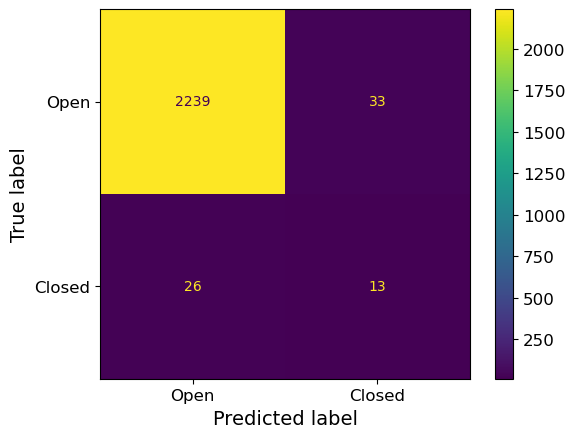

Test set accuracy score for Decision Tree Model is  0.9744699264387711
Test set recall score for Decision Tree Model is  0.3333333333333333
Test set precision score for Decision Tree Model is  0.2826086956521739
Test set F1 score for Decision Tree Model is  0.30588235294117644


In [34]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest

In [35]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [36]:
rnd_clf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9836959550216033


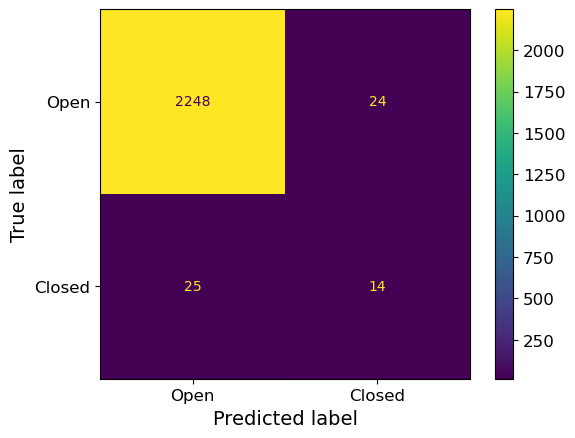

Test set accuracy score for Random Forest Model is  0.9787970575508438
Test set recall score for Random Forest Model is  0.358974358974359
Test set precision score for Random Forest Model is  0.3684210526315789
Test set F1 score for Random Forest Model is  0.36363636363636365


In [37]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3= accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3= recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3= precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13= f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of data with hourly data available

In [38]:
#add hourly data max precipitation rates

hourly['time']= hourly['DATE'].dt.hour
hourly['DATE']=hourly['DATE'].dt.date

max_precipitation = hourly.groupby('DATE').apply(lambda x: x.loc[x['HPCP'].idxmax()])
max_precipitation = max_precipitation[['DATE', 'time', 'HPCP']]

max_precipitation['Max Precip. Time'] = max_precipitation['time'].astype('int')
max_precipitation['Max Precip. Rate']= max_precipitation['HPCP']

max_precipitation = max_precipitation.drop(columns = ['time', 'HPCP'])
max_precipitation.reset_index(drop=True, inplace=True)
max_precipitation['DATE']=pd.to_datetime(max_precipitation['DATE'])

max_precipitation

,DATE,Max Precip. Time,Max Precip. Rate
0,1963-11-01,1,0.00
1,1963-11-24,0,0.00
2,1963-12-01,6,0.01
3,1963-12-04,13,0.01
4,1963-12-05,5,0.01
...,...,...,...
8567,2013-12-27,0,0.00
8568,2013-12-29,13,0.00
8569,2013-12-30,23,0.01
8570,2013-12-31,1,0.02


In [39]:
whourly = pd.merge(school, max_precipitation, how='inner', on='DATE')
print(whourly.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      4015 non-null   datetime64[ns]
 1   Closure Type              4015 non-null   float64       
 2   Station                   4015 non-null   int64         
 3   MultidaySnowfallTotal     4015 non-null   float64       
 4   PrecipitationTotal        4015 non-null   float64       
 5   SnowfallTotal             4015 non-null   float64       
 6   SnowDepth                 4015 non-null   float64       
 7   MaxTemp                   4015 non-null   float64       
 8   MinTemp                   4015 non-null   float64       
 9   Fog/IceFog/FreezingFog    4015 non-null   float64       
 10  Thunder                   4015 non-null   float64       
 11  Ice/Sleet                 4015 non-null   float64       
 12  Hail                

In [40]:
missing_dates2=date_range[~date_range.isin(whourly['DATE'])]
winter_missing_dates2 = missing_dates2[missing_dates2.month.isin([10,11,12,1,2,3,4,5])]
print(missing_dates2, winter_missing_dates2)
print(whourly['Closure Type'].value_counts())
#10826 missing winter weather days
#96 closures to look at now instead of 154

DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=18265, freq=None) DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=10823, freq=None)
Closure Type
0.0    3919
1.0      96
Name: count, dtype: int64


In [41]:
#create previous day's max precip. rate and time
whourly['Previous Max Precip. Rate'] = whourly['Max Precip. Rate'].shift(1)
whourly['Previous Max Precip. Time'] = whourly['Max Precip. Time'].shift(1)

whourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DATE                       4015 non-null   datetime64[ns]
 1   Closure Type               4015 non-null   float64       
 2   Station                    4015 non-null   int64         
 3   MultidaySnowfallTotal      4015 non-null   float64       
 4   PrecipitationTotal         4015 non-null   float64       
 5   SnowfallTotal              4015 non-null   float64       
 6   SnowDepth                  4015 non-null   float64       
 7   MaxTemp                    4015 non-null   float64       
 8   MinTemp                    4015 non-null   float64       
 9   Fog/IceFog/FreezingFog     4015 non-null   float64       
 10  Thunder                    4015 non-null   float64       
 11  Ice/Sleet                  4015 non-null   float64       
 12  Hail  

In [42]:
whourly = whourly.drop(columns=['DATE', 'School Year', 'MinTempChange', 'MaxTempChange', 'SnowfallTotalChange', 'SnowDepthChange', 'Closure_shift'])

# data correlations and more drops

In [43]:
whourly.corr()['Closure Type'].sort_values()

MinTemp                     -0.183879
MaxTemp                     -0.176822
Previous_MaxTemp            -0.166645
Previous_MinTemp            -0.162362
Month                       -0.090804
Max Precip. Time            -0.073784
3DayVector_MinTemp          -0.060637
3DayVector_MaxTemp          -0.041276
Thunder                     -0.026996
Day of the Week             -0.016530
Day                         -0.010539
Previous Max Precip. Rate   -0.003659
Max Precip. Rate            -0.003574
WaterEqSnowfall             -0.002470
Hail                         0.012964
HighWinds                    0.021297
Previous Max Precip. Time    0.037095
PrecipitationTotal           0.037852
MultidaySnowfallTotal        0.045151
Ice/Sleet                    0.048005
Year                         0.059771
Fog/IceFog/FreezingFog       0.071589
Previous Early Dismissal     0.100847
3DayVector_SnowfallTotal     0.123245
Station                      0.132817
3DayVector_SnowDepth         0.141909
Glaze       

In [44]:
ready =whourly.drop(columns=['3DayVector_MaxTemp', 'Thunder', 'Day', 'Day of the Week', 'Previous Max Precip. Rate', 'Max Precip. Rate', 'WaterEqSnowfall', 'Hail', 'HighWinds', 'PrecipitationTotal', 'Previous Max Precip. Time',  'MultidaySnowfallTotal', 'Ice/Sleet'])

In [45]:
ready.corr()['Closure Type'].sort_values()

MinTemp                    -0.183879
MaxTemp                    -0.176822
Previous_MaxTemp           -0.166645
Previous_MinTemp           -0.162362
Month                      -0.090804
Max Precip. Time           -0.073784
3DayVector_MinTemp         -0.060637
Year                        0.059771
Fog/IceFog/FreezingFog      0.071589
Previous Early Dismissal    0.100847
3DayVector_SnowfallTotal    0.123245
Station                     0.132817
3DayVector_SnowDepth        0.141909
Glaze                       0.158840
Previous_SnowfallTotal      0.177974
Previous_SnowDepth          0.178214
WaterEqGroundSnow           0.189894
Snow Days This Year         0.201860
SnowDepth                   0.221076
SnowfallTotal               0.256937
Closure Type                1.000000
Name: Closure Type, dtype: float64

# resplit data (w/ hourly)

In [46]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (w/ hourly data)

In [48]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.8266462784097159


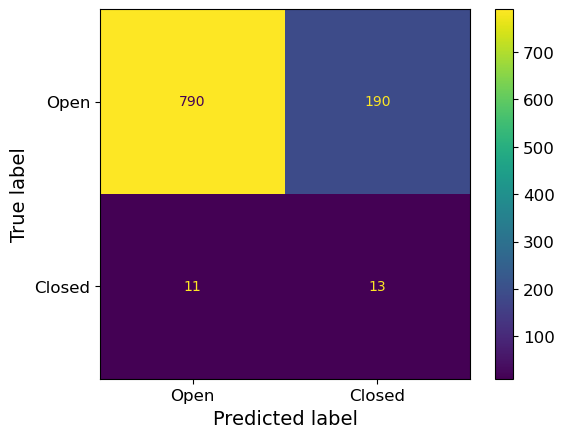

Test set accuracy score for Logistic Regression Model is  0.799800796812749
Test set recall score for Logistic Regression Model is  0.5416666666666666
Test set precision score for Logistic Regression Model is  0.06403940886699508
Test set F1 score for Logistic Regression Model is  0.1145374449339207


In [49]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (w/ hourly data)

In [50]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [51]:
dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9598127653957007


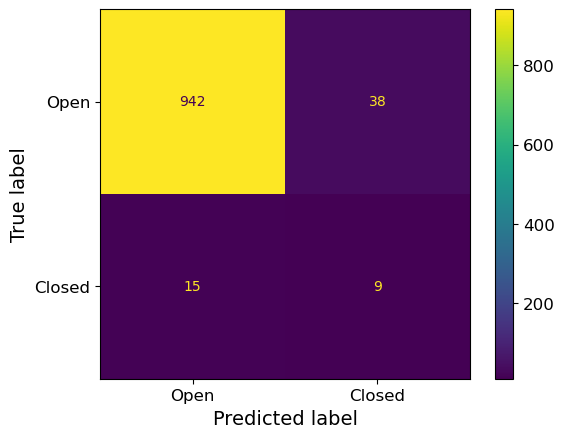

Test set accuracy score for Decision Tree Model is  0.9472111553784861
Test set recall score for Decision Tree Model is  0.375
Test set precision score for Decision Tree Model is  0.19148936170212766
Test set F1 score for Decision Tree Model is  0.25352112676056343


In [52]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (w/ hourly data)

In [53]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [54]:
rnd_clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9760852346483027


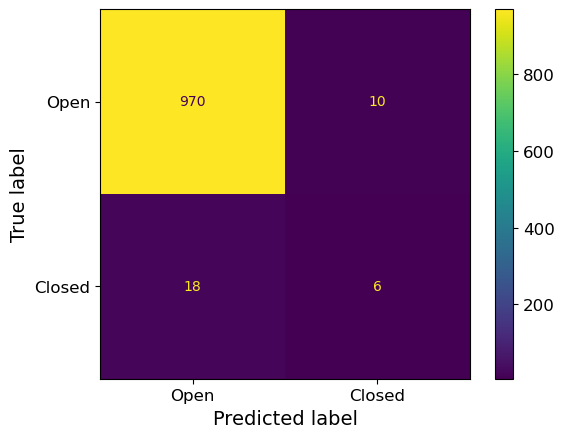

Test set accuracy score for Random Forest Model is  0.9721115537848606
Test set recall score for Random Forest Model is  0.25
Test set precision score for Random Forest Model is  0.375
Test set F1 score for Random Forest Model is  0.3


In [55]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of just extreme weather data and school closures (more balanced data set)

In [56]:
snow = full['SnowfallTotal']>1
temp=full['MinTemp']<32
closure=full['Closure Type'] == 1

extreme_subset = full[snow|temp|closure]

extreme_subset['Closure Type'].value_counts()

Closure Type
0.0    4942
1.0     154
Name: count, dtype: int64

# data correlations and more drops

In [57]:
extreme_subset.corr()['Closure Type'].sort_values()

MaxTemp                    -0.131381
Previous_MaxTemp           -0.110757
MinTemp                    -0.084882
Previous_MinTemp           -0.079579
Month                      -0.074708
Thunder                    -0.017572
Day of the Week            -0.014837
3DayVector_MaxTemp         -0.011899
Day                        -0.010955
3DayVector_MinTemp          0.004129
Hail                        0.018074
Ice/Sleet                   0.028315
MultidaySnowfallTotal       0.033885
HighWinds                   0.042973
Fog/IceFog/FreezingFog      0.060885
Previous Early Dismissal    0.079363
Glaze                       0.090036
PrecipitationTotal          0.093735
School Year                 0.095650
Year                        0.097038
Previous_SnowDepth          0.106566
Station                     0.121281
3DayVector_SnowDepth        0.126473
3DayVector_SnowfallTotal    0.126577
WaterEqSnowfall             0.138112
SnowDepth                   0.150759
Previous_SnowfallTotal      0.151152
W

In [58]:
ready =extreme_subset.drop(columns=['Thunder', '3DayVector_MaxTemp',  'Day', 'Day of the Week', '3DayVector_MinTemp','Hail', 'Ice/Sleet', 'MultidaySnowfallTotal',  'HighWinds'])

In [59]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.131381
Previous_MaxTemp           -0.110757
MinTemp                    -0.084882
Previous_MinTemp           -0.079579
Month                      -0.074708
Fog/IceFog/FreezingFog      0.060885
Previous Early Dismissal    0.079363
Glaze                       0.090036
PrecipitationTotal          0.093735
School Year                 0.095650
Year                        0.097038
Previous_SnowDepth          0.106566
Station                     0.121281
3DayVector_SnowDepth        0.126473
3DayVector_SnowfallTotal    0.126577
WaterEqSnowfall             0.138112
SnowDepth                   0.150759
Previous_SnowfallTotal      0.151152
WaterEqGroundSnow           0.192808
Snow Days This Year         0.204491
SnowfallTotal               0.253882
Closure Type                1.000000
Name: Closure Type, dtype: float64

# resplit data (for extreme subset)

In [60]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (extreme subset)

In [62]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.8312454718193376


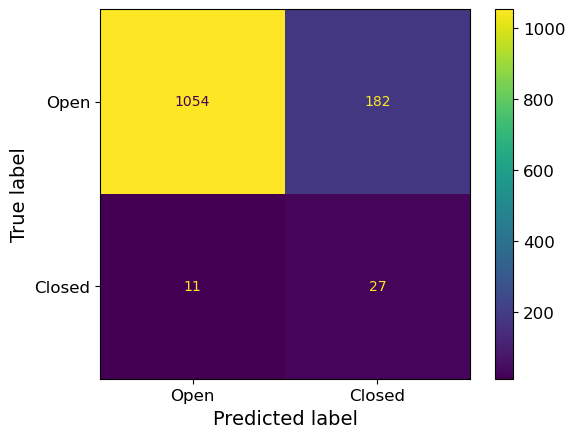

Test set accuracy score for Logistic Regression Model is  0.8485086342229199
Test set recall score for Logistic Regression Model is  0.7105263157894737
Test set precision score for Logistic Regression Model is  0.1291866028708134
Test set F1 score for Logistic Regression Model is  0.21862348178137653


In [63]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (extreme subset)

In [64]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [65]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 1, min_samples_split =2, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.8997887988189138


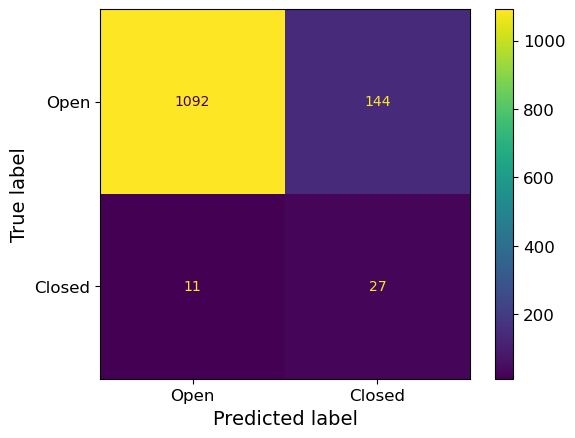

Test set accuracy score for Decision Tree Model is  0.8783359497645212
Test set recall score for Decision Tree Model is  0.7105263157894737
Test set precision score for Decision Tree Model is  0.15789473684210525
Test set F1 score for Decision Tree Model is  0.25837320574162675


In [66]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (extreme subset)

In [67]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [68]:
rnd_clf = RandomForestClassifier(n_estimators = 150, criterion = 'entropy', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9654600631553046


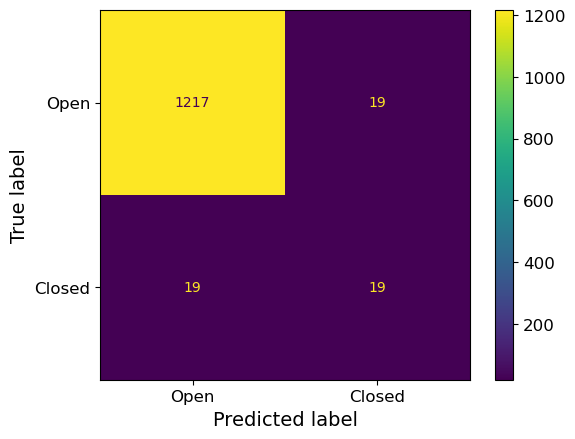

Test set accuracy score for Random Forest Model is  0.9701726844583988
Test set recall score for Random Forest Model is  0.5
Test set precision score for Random Forest Model is  0.5
Test set F1 score for Random Forest Model is  0.5


In [69]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

In [70]:
probabilities_rt = rnd_clf.predict_proba(X_test)

rt_prob_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': rnd_clf.predict(X_test),
    '% Chance of School': probabilities_rt[:, 0],
    '% Chance of Snow Day':probabilities_rt[:, 1]})
rt_prob_df

,True_Label,Predicted_Label,% Chance of School,% Chance of Snow Day
9111,0.0,0.0,0.942126,0.057874
15300,0.0,0.0,0.977908,0.022092
18980,0.0,0.0,0.829614,0.170386
17804,0.0,0.0,0.988053,0.011947
2207,0.0,0.0,0.988293,0.011707
...,...,...,...,...
9809,0.0,0.0,0.928339,0.071661
5826,0.0,0.0,1.000000,0.000000
1879,0.0,0.0,0.998636,0.001364
20442,0.0,0.0,0.996988,0.003012


/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


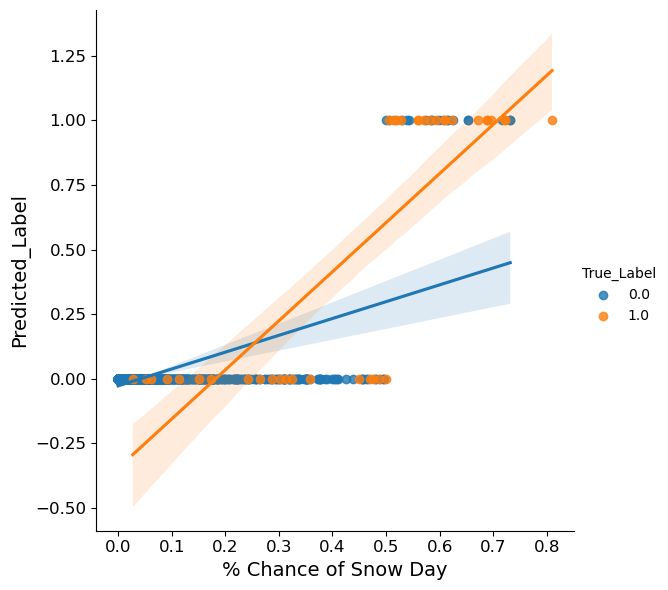

In [71]:
seaborn.lmplot( x="% Chance of Snow Day", y="Predicted_Label",hue="True_Label",data=rt_prob_df, height = 6)

In [72]:
date_predict=pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': rnd_clf.predict(X_test)})

misclassified=date_predict[date_predict['True_Label']!=date_predict['Predicted_Label']]
misclassified_info=pd.merge(misclassified, full, left_index=True, right_index=True)
misclassified_info

,True_Label,Predicted_Label,Closure Type,Station,MultidaySnowfallTotal,PrecipitationTotal,SnowfallTotal,SnowDepth,MaxTemp,MinTemp,...,School Year,Snow Days This Year,Previous_MinTemp,Previous_MaxTemp,Previous_SnowfallTotal,Previous_SnowDepth,3DayVector_MinTemp,3DayVector_MaxTemp,3DayVector_SnowfallTotal,3DayVector_SnowDepth
7649,1.0,0.0,1.0,0,0.0,0.16,3.5,10.0,14.000000,-2.0,...,1981,0.0,-21.0,7.000000,1.3,9.0,-4.666667,-2.333333,1.000000e+00,1.666667
9104,1.0,0.0,1.0,0,0.0,0.16,0.0,2.0,33.000000,30.0,...,1985,0.0,29.0,36.000000,0.0,2.0,2.666667,0.000000,0.000000e+00,-0.666667
11992,1.0,0.0,1.0,0,0.0,0.00,0.0,18.0,23.000000,13.0,...,1993,7.0,11.0,22.000000,7.0,21.0,2.000000,1.333333,-5.000000e-01,0.333333
12334,1.0,0.0,1.0,0,0.0,0.05,0.0,2.0,42.000000,27.0,...,1994,0.0,18.0,30.000000,0.0,4.0,3.666667,6.000000,0.000000e+00,-1.000000
12356,0.0,1.0,0.0,0,0.0,0.38,7.0,10.0,27.000000,12.0,...,1994,0.0,14.0,25.000000,0.3,7.0,-3.333333,-2.666667,2.166667e+00,1.000000
12379,1.0,0.0,1.0,0,0.0,0.28,0.0,0.0,36.000000,28.0,...,1994,0.0,29.0,36.000000,0.0,1.0,5.333333,1.000000,7.401487e-17,-0.333333
12661,1.0,0.0,1.0,0,0.0,0.15,0.0,0.0,45.000000,15.0,...,1995,0.0,10.0,19.000000,0.0,0.0,3.333333,11.333333,-5.000000e-01,0.000000
14188,1.0,0.0,1.0,0,0.0,0.00,1.5,0.0,36.000000,15.0,...,1999,0.0,18.0,39.000000,0.0,0.0,-2.333333,0.666667,5.000000e-01,0.000000
14434,1.0,0.0,1.0,0,0.0,0.50,0.0,0.0,30.000000,23.0,...,2000,0.0,26.0,40.000000,0.0,3.0,-2.333333,-2.666667,0.000000e+00,0.000000
14454,1.0,0.0,1.0,0,0.0,0.00,0.5,0.0,37.000000,24.0,...,2000,0.0,21.0,30.000000,0.0,0.0,2.000000,1.666667,1.666667e-01,0.000000


/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


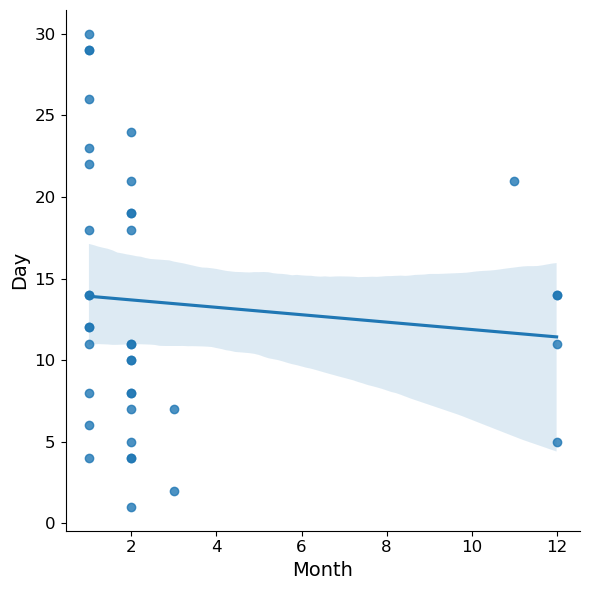

In [73]:
seaborn.lmplot( x="Month", y="Day",data=misclassified_info, height = 6)

# creating subset of just extreme weather data that also contains hourly data

In [74]:
snow = whourly['SnowfallTotal']>1
temp=whourly['MinTemp']<32
closure=whourly['Closure Type'] == 1

extremehourly_subset = whourly[snow|temp|closure]

extremehourly_subset['Previous Max Precip. Time']= extremehourly_subset['Previous Max Precip. Time'].fillna(0)

extremehourly_subset['Closure Type'].value_counts()

/var/folders/fh/dvn_79bs6b58szfg1vfz4g740000gn/T/ipykernel_4987/2910752394.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extremehourly_subset['Previous Max Precip. Time']= extremehourly_subset['Previous Max Precip. Time'].fillna(0)


Closure Type
0.0    1887
1.0      96
Name: count, dtype: int64

# data correlations and more drops

In [75]:
extremehourly_subset.corr()['Closure Type'].sort_values()

MaxTemp                     -0.140513
MinTemp                     -0.135731
Previous_MaxTemp            -0.119349
Previous_MinTemp            -0.105197
Max Precip. Time            -0.092265
Month                       -0.067341
Day of the Week             -0.025448
3DayVector_MinTemp          -0.024244
Thunder                     -0.020343
3DayVector_MaxTemp          -0.012600
Previous Max Precip. Rate   -0.007135
WaterEqSnowfall             -0.005066
Max Precip. Rate            -0.004853
Day                         -0.003540
Hail                         0.030352
MultidaySnowfallTotal        0.042271
Ice/Sleet                    0.047336
HighWinds                    0.066852
Previous Max Precip. Time    0.071134
PrecipitationTotal           0.072795
Year                         0.089108
Previous Early Dismissal     0.099586
3DayVector_SnowfallTotal     0.108823
Fog/IceFog/FreezingFog       0.121289
3DayVector_SnowDepth         0.127808
Station                      0.134275
Previous_Sno

In [76]:
ready =extremehourly_subset.drop(columns=['3DayVector_MinTemp', 'Thunder','3DayVector_MaxTemp',  'Day of the Week', 'Previous Max Precip. Rate', 'Day', 'WaterEqSnowfall', 'Max Precip. Rate', 'Hail', 'MultidaySnowfallTotal', 'Ice/Sleet'])

In [77]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                     -0.140513
MinTemp                     -0.135731
Previous_MaxTemp            -0.119349
Previous_MinTemp            -0.105197
Max Precip. Time            -0.092265
Month                       -0.067341
HighWinds                    0.066852
Previous Max Precip. Time    0.071134
PrecipitationTotal           0.072795
Year                         0.089108
Previous Early Dismissal     0.099586
3DayVector_SnowfallTotal     0.108823
Fog/IceFog/FreezingFog       0.121289
3DayVector_SnowDepth         0.127808
Station                      0.134275
Previous_SnowDepth           0.136504
Previous_SnowfallTotal       0.138374
Glaze                        0.152542
SnowDepth                    0.178763
Snow Days This Year          0.188999
WaterEqGroundSnow            0.201253
SnowfallTotal                0.216398
Closure Type                 1.000000
Name: Closure Type, dtype: float64

In [78]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1983 entries, 0 to 4014
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Closure Type               1983 non-null   float64
 1   Station                    1983 non-null   int64  
 2   PrecipitationTotal         1983 non-null   float64
 3   SnowfallTotal              1983 non-null   float64
 4   SnowDepth                  1983 non-null   float64
 5   MaxTemp                    1983 non-null   float64
 6   MinTemp                    1983 non-null   float64
 7   Fog/IceFog/FreezingFog     1983 non-null   float64
 8   Glaze                      1983 non-null   float64
 9   HighWinds                  1983 non-null   float64
 10  WaterEqGroundSnow          1983 non-null   float64
 11  Month                      1983 non-null   int32  
 12  Year                       1983 non-null   int32  
 13  Previous Early Dismissal   1983 non-null   float64
 1

# resplit data (for extreme hourly subset)

In [79]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (extreme hourly subset)

In [81]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

from sklearn.metrics import accuracy_score
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.7532015236713223


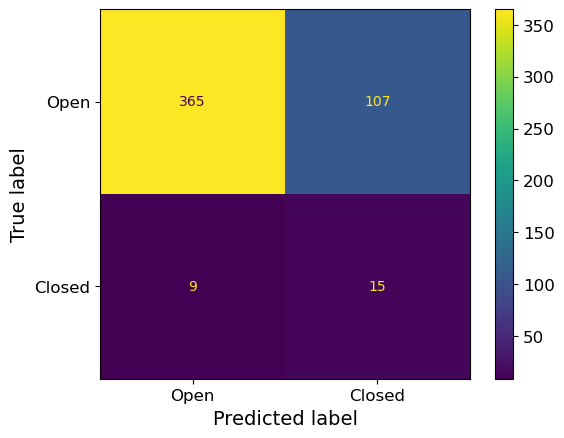

Test set accuracy score for Logistic Regression Model is  0.7661290322580645
Test set recall score for Logistic Regression Model is  0.625
Test set precision score for Logistic Regression Model is  0.12295081967213115
Test set F1 score for Logistic Regression Model is  0.2054794520547945


In [82]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (extreme hourly subset)

In [83]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [84]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9098811899147469


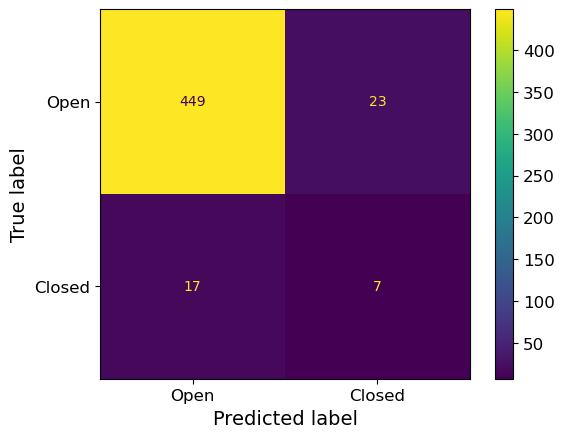

Test set accuracy score for Decision Tree Model is  0.9193548387096774
Test set recall score for Decision Tree Model is  0.2916666666666667
Test set precision score for Decision Tree Model is  0.23333333333333334
Test set F1 score for Decision Tree Model is  0.2592592592592593


In [85]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (extreme hourly subset)

In [86]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


In [87]:
rnd_clf = RandomForestClassifier(n_estimators = 150, criterion = 'gini', max_depth = None, min_samples_leaf = 4, min_samples_split =10, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9582985670233993


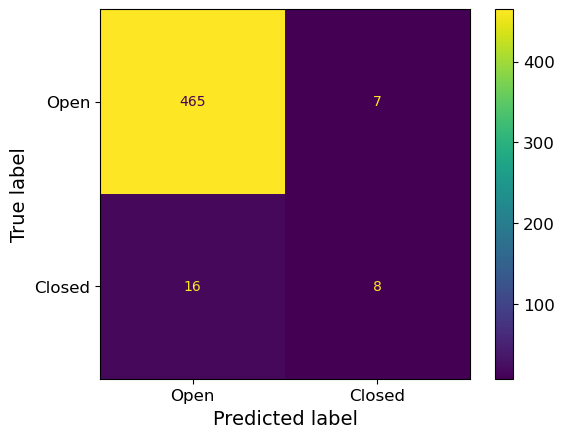

Test set accuracy score for Random Forest Model is  0.9536290322580645
Test set recall score for Random Forest Model is  0.3333333333333333
Test set precision score for Random Forest Model is  0.5333333333333333
Test set F1 score for Logistic Random Forest is  0.4102564102564102


In [88]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Logistic Random Forest is ' , f13)